In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import yaml

from pyoperators import *
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

import qubic
from qubic.lib.Calibration.Qselfcal import scatter_plot_FP, get_TEScoordinates_ONAFP
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Instrument.Qacquisition import QubicMultiAcquisitions
from qubic.lib.MapMaking.Qmaps import InputMaps
from qubic.lib.Qsamplings import get_pointing
%matplotlib inline

# Nsub_in

In [3]:
def get_dict(params, comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": params["QUBIC"]["npointings"],
        "nf_recon": params["QUBIC"]["nrec"],
        "nf_sub": params["QUBIC"][f"nsub_{key}"],
        "nside": params["SKY"]["nside"],
        "MultiBand": True,
        "period": 1,
        "RA_center": params["SKY"]["RA_center"],
        "DEC_center": params["SKY"]["DEC_center"],
        "filter_nu": 150 * 1e9,
        "noiseless": False,
        "comm": comm,
        "dtheta": params["QUBIC"]["dtheta"],
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": True,
        "nhwp_angles": 3,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(params["QUBIC"]["NOISE"]["detector_nep"]),
        "synthbeam_kmax": params["QUBIC"]["SYNTHBEAM"]["synthbeam_kmax"],
        "synthbeam_fraction": 1,
        "beam_shape": 'gaussian',
        "debug":False,
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubic.lib.Qdictionary.qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic

In [4]:
def get_sky_config(params, comm):
        """Sky configuration.

        Method that read 'params.yml' file and create dictionary containing sky emission model.

        Returns
        -------
        dict_sky: dict
            Sky config dictionary.

        Notes
        -----
        Note that the key denote the emission and the value denote the sky model using PySM convention.
        For CMB, seed denote the realization.

        Example
        -------
        d = {'cmb':seed, 'dust':'d0', 'synchrotron':'s0'}

        """

        dict_sky = {}

        if params["CMB"]["cmb"]:
            if params["CMB"]["seed"] == 0:
                if comm.Get_rank() == 0:
                    seed = np.random.randint(10000000)
                else:
                    seed = None
                seed = comm.bcast(seed, root=0)
            else:
                seed = params["CMB"]["seed"]
                
            dict_sky["cmb"] = seed

        for j in params["Foregrounds"]:
            # print(j, params['Foregrounds'][j])
            if j == "Dust":
                if params["Foregrounds"][j]:
                    dict_sky["dust"] = "d0"
            elif j == "Synchrotron":
                if params["Foregrounds"][j]:
                    dict_sky["synchrotron"] = "s0"

        return dict_sky

In [5]:
# Initialize pipeline arguments
comm = MPI.COMM_WORLD

with open('params.yml', 'r') as file:
    params = yaml.safe_load(file)

In [6]:
# Acquisition arguments
dict_qubic = get_dict(params, comm)

In [7]:
sky = get_sky_config(params, comm)
sampling = get_pointing(dict_qubic)
q = QubicInstrument(dict_qubic)

You asked 10 pointings with repeat strategy so I will provide 3 pointings repeated 3 times.


In [8]:
center = qubic.lib.Qsamplings.equ2gal(dict_qubic['RA_center'], dict_qubic['DEC_center'])

In [9]:
992*9

8928

# Sub-TOD

In [10]:
nsub_max = 40
nsub_list = np.arange(0, nsub_max)

In [11]:
acq = QubicMultiAcquisitions(dict_qubic, nsub_max*2, params['QUBIC']['nrec'], sampling=sampling)
ext = InputMaps(sky, acq.allnus, params['QUBIC']['nrec'], params['SKY']['nside'])

H = acq.H[:nsub_max]
input_maps = ext.m_nu
input_maps_ones = np.ones(np.shape(input_maps))
# input_maps_ones[..., 1] = 0
# input_maps_ones[..., 2] = 0

Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3

In [12]:
TOD_ones = []
for i in range(nsub_max):
    C = HealpixConvolutionGaussianOperator(acq.allfwhm[i])
    TOD_ones.append(H[i](C(input_maps_ones[i])))

In [13]:
TOD_ones[0].shape

(992, 9)

([<matplotlib.axis.XTick at 0x7f38c81b22f0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20'),
  Text(22, 0, '22'),
  Text(24, 0, '24'),
  Text(26, 0, '26'),
  Text(28, 0, '28'),
  Text(30, 0, '30'),
  Text(32, 0, '32'),
  Text(34, 0, '34'),
  Text(36, 0, '36'),
  Text(38, 0, '38')])

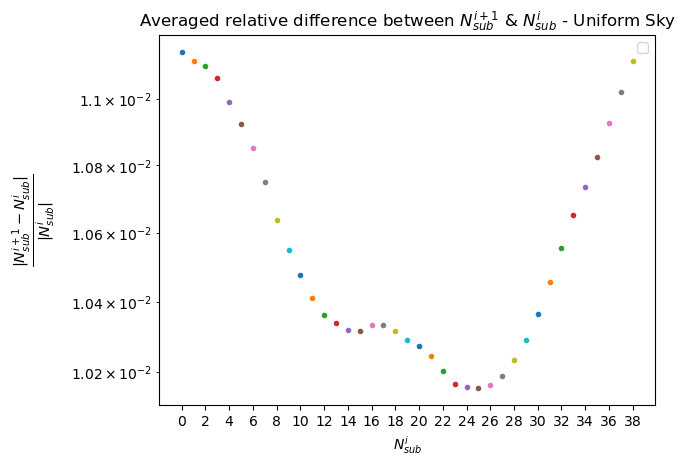

In [14]:
plt.figure()
for i in range(nsub_max-1):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_ones[i+1] - TOD_ones[i])/TOD_ones[i])), '.')
plt.legend()
plt.title(r"Averaged relative difference between $N_{sub}^{i+1}$ & $N_{sub}^i$ - Uniform Sky")
plt.ylabel(r'$\frac{| N_{sub}^{i+1} - N_{sub}^i |}{| N_{sub}^{i} |}$', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')
plt.xticks(np.arange(0, nsub_max-1, 2))

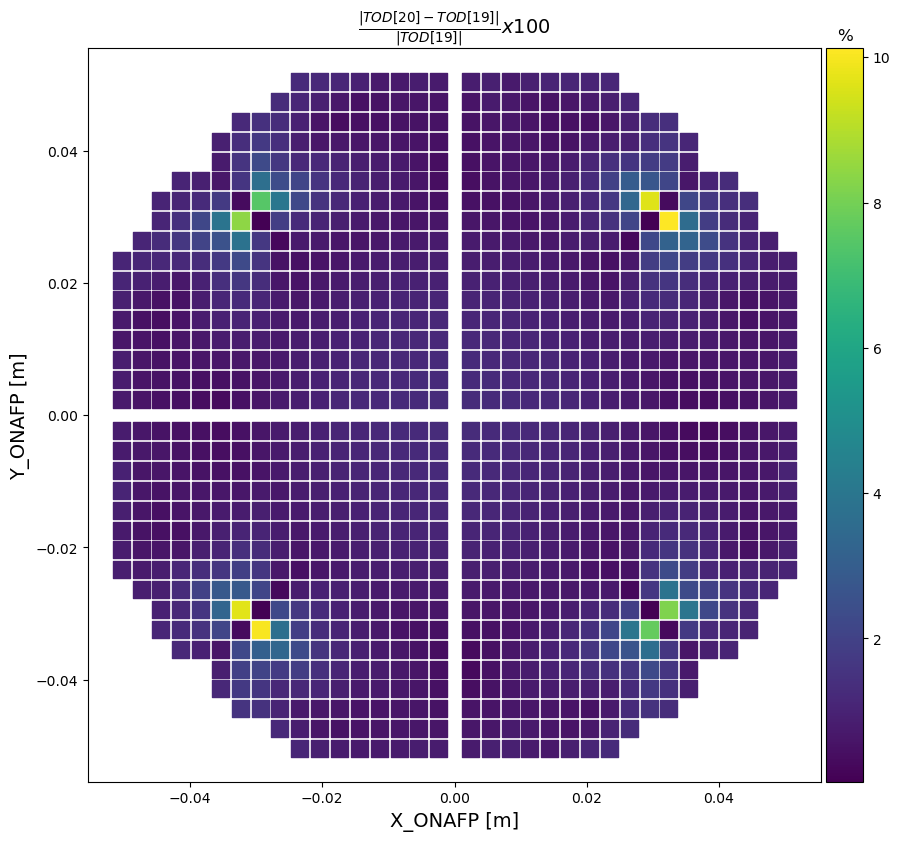

In [15]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_ones[20] - TOD_ones[19]) / np.abs(TOD_ones[19]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD[20] - TOD[19] |}{| TOD[19] |} x 100$', fig=fig, ax = ax, unit='%')

# Operators details

In [16]:
H[0].operands

[ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,9), shapeout=(992,9)),
 DiagonalOperator(array([0.00032418261245316713, ..., 0.00032418261245316713], dtype=float64), broadcast='rightward', None),
 ReshapeOperator((992,9,1), (992,9), None),
 DenseBlockDiagonalOperator(array([[[[1.2571071550604747e-21, ..., -1.0886867315615543e-21]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,9,3), shapeout=(992,9,1)),
 ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,9,3))]

In [17]:
Rdet_list = []
Tinst_list = []
Idet_list = []
Pol_list = []
Proj_list = []
Hwp_list = []
Filt_list = []
Ap_list = []
Unit_list = []
C_list = []
for i in range(nsub_max):
    Rdet_list.append(acq.subacqs[i].get_detector_response_operator())
    Tinst_list.append(acq.multiinstrument[i].get_transmission_operator())
    Idet_list.append(acq.subacqs[i].get_detector_integration_operator())
    Pol_list.append(acq.subacqs[i].get_polarizer_operator())
    Proj_list.append(acq.subacqs[i].get_projection_operator())
    Hwp_list.append(acq.multiinstrument[i].get_hwp_operator(sampling, acq.scene))
    Filt_list.append(acq.subacqs[i].get_filter_operator())
    Ap_list.append(acq.subacqs[i].get_aperture_integration_operator())
    Unit_list.append(acq.subacqs[i].get_unit_conversion_operator())
    C_list.append(HealpixConvolutionGaussianOperator(acq.allfwhm[i]))

Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3

In [18]:
Proj_list[0].shapeout

(992, 9, 3)

## Input Maps

Text(0.5, 0, '$i$')

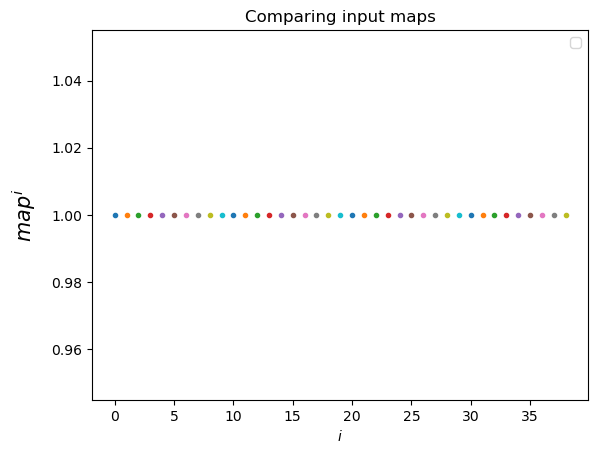

In [19]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(input_maps_ones[i]), '.')
plt.legend()
plt.title(r"Comparing input maps")
plt.ylabel(r'$map^i$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

Text(0.5, 0, '$i$')

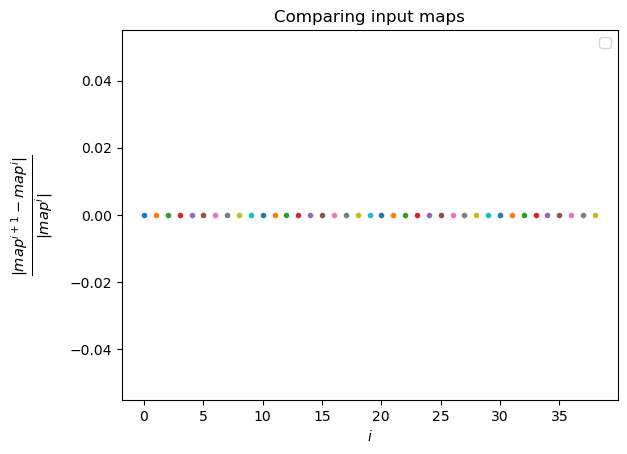

In [20]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((input_maps_ones[i+1] - input_maps_ones[i])/input_maps_ones[i])), '.')
plt.legend()
plt.title(r"Comparing input maps")
plt.ylabel(r'$\frac{| map^{i+1} - map^i |}{| map^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

GOOD

## Convolution operator

In [21]:
test_conv = []
for i in range(nsub_max):
    C = C_list[i]
    test_conv.append(C(input_maps_ones[i]))

In [22]:
test_conv[0].shape

(196608, 3)

Text(0.5, 0, 'Frequency (GHz)')

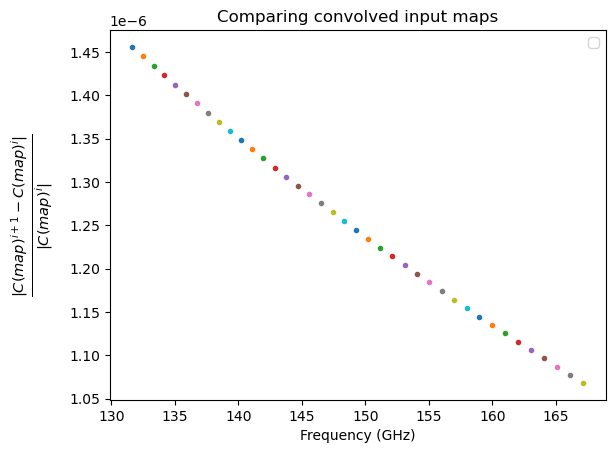

In [23]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(acq.allnus[i], np.mean(np.abs((test_conv[i+1] - test_conv[i])/test_conv[i])), '.')
plt.legend()
plt.title(r"Comparing convolved input maps")
plt.ylabel(r'$\frac{| C(map)^{i+1} - C(map)^i |}{| C(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'Frequency (GHz)')

Text(0, 0.5, 'FWHM')

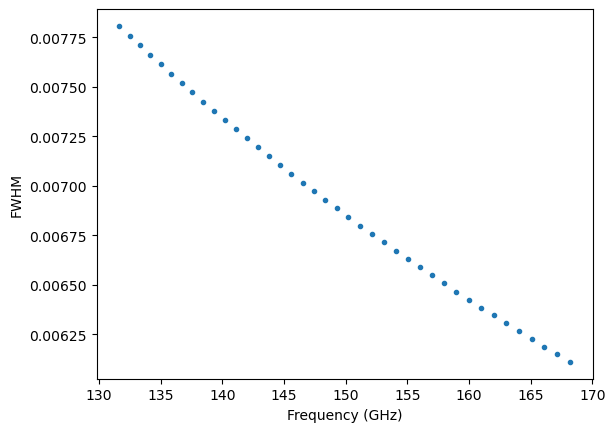

In [24]:
plt.plot(acq.allnus[:nsub_max], acq.allfwhm[:nsub_max], '.')
plt.xlabel('Frequency (GHz)')
plt.ylabel('FWHM')

Text(0.5, 1.0, 'Compison between successive FWHM')

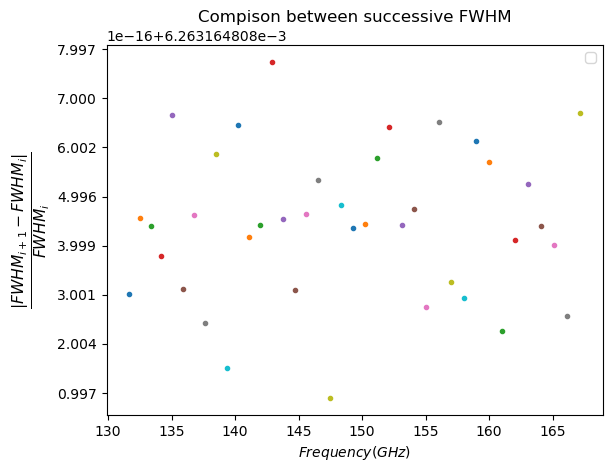

In [25]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(acq.allnus[i], np.abs(acq.allfwhm[i+1]-acq.allfwhm[i])/acq.allfwhm[i] , '.')
plt.legend()
plt.ylabel(r'$\frac{|FWHM_{i+1} - FWHM_{i}|}{FWHM_{i}}$', fontsize=16)
plt.xlabel(r'$Frequency (GHz)$')
plt.title('Compison between successive FWHM')

OK

## Temperature Operator

In [26]:
test_temp = []
for i in range(nsub_max):
    Unit = Unit_list[i]
    test_temp.append(Unit(input_maps_ones[i]))

In [27]:
test_temp[0].shape

(196608, 3)

Text(0.5, 0, 'Frequency (GHz)')

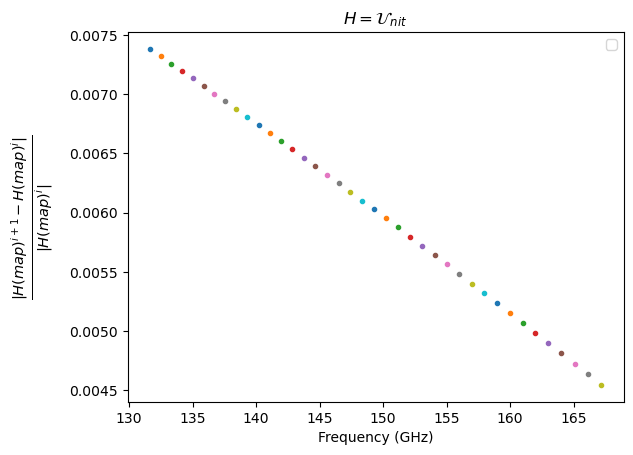

In [28]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(acq.allnus[i], np.mean(np.abs((test_temp[i+1] - test_temp[i])/test_temp[i])), '.')
plt.legend()
plt.title(r"$H = \mathcal{U}_{nit}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')

Text(0.5, 0, '$Frequency (GHz) $')

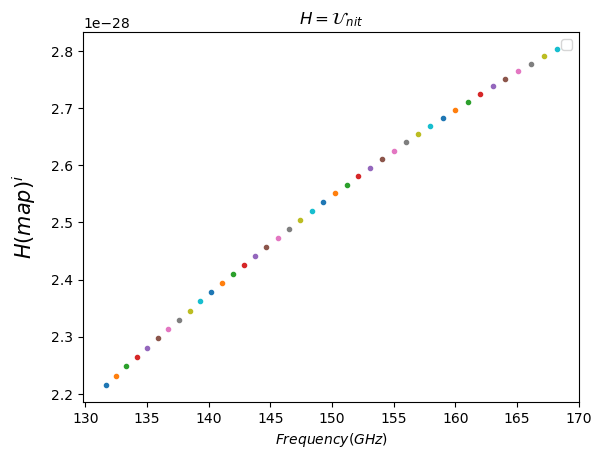

In [29]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(acq.allnus[i], np.mean(test_temp[i]), '.')
plt.legend()
plt.title(r"$H = \mathcal{U}_{nit}$")
plt.ylabel(r'$H(map)^i$', fontsize=15, labelpad=10)
plt.xlabel(r'$Frequency (GHz) $')

$\mathcal{U}_{nit} = \frac{10^{-6}}{T} \frac{2\Omega_{pix}h\nu^3}{c^2} \frac{h\nu}{kT} \frac{e^{\frac{h\nu}{kT}}}{(e^{\frac{h\nu}{kT}} - 1)^2}$

In [30]:
from scipy.constants import c, h, k
def u_nit(nu):
    a = 2 * acq.scene.solid_angle * h * nu**3 / c**2
    T = acq.scene.temperature
    hnu_kt = h * nu / (k * T)
    return 1e-6 * a * hnu_kt * np.exp(hnu_kt) / (np.expm1(hnu_kt)**2 * T)

Text(0, 0.5, '$\\mathcal{U}_{nit} (W / m^2 / Hz / K)$')

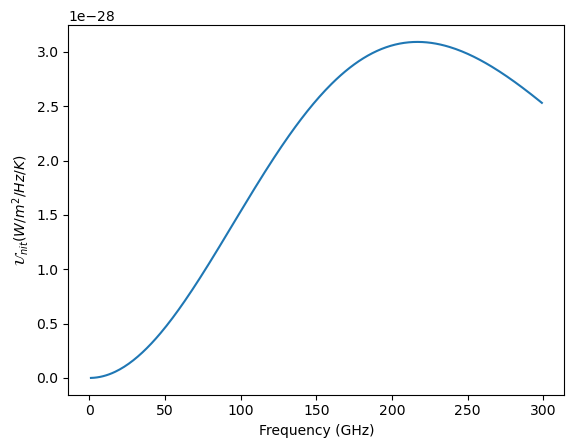

In [31]:
plt.plot(u_nit(np.linspace(0, 300, 300)*1e9))
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'$\mathcal{U}_{nit} (W / m^2 / Hz / K)$')

Text(0.5, 1.0, '$\\mathcal{U}_{nit}$')

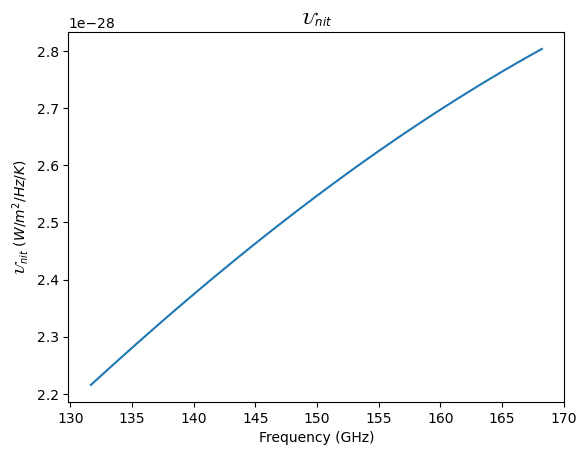

In [32]:
plt.plot(acq.allnus[:nsub_max], u_nit(acq.allnus[:nsub_max]*1e9))
plt.xlabel("Frequency (GHz)")
plt.ylabel(r'$\mathcal{U}_{nit}$ ($W / m^2 / Hz / K$)')
plt.title(r'$\mathcal{U}_{nit}$')

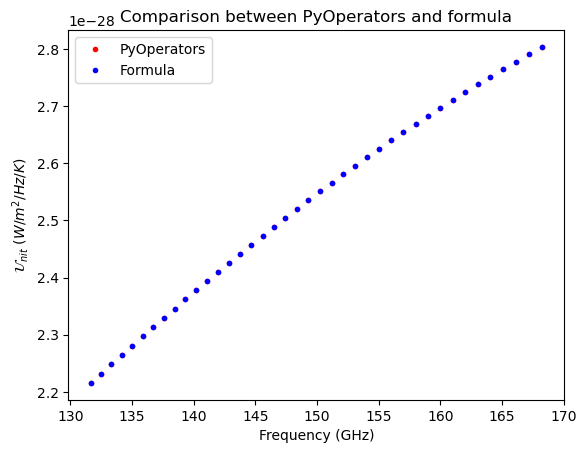

In [33]:
for i in range(nsub_max):
    plt.plot(acq.allnus[i], Unit_list[i](1), '.r')
    plt.plot(acq.allnus[i], u_nit(acq.allnus[i]*1e9), '.b')
plt.xlabel("Frequency (GHz)")
plt.ylabel(r'$\mathcal{U}_{nit}$ ($W / m^2 / Hz / K$)')
plt.title(r'Comparison between PyOperators and formula')
plt.plot([], [], '.r', label='PyOperators')
plt.plot([], [], '.b', label='Formula')
plt.legend()

In [34]:
print((acq.allnus*1e9) - np.array([acq.multiinstrument[i].filter.nu for i in range(len(acq.multiinstrument))]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [35]:
a = asoperator(u_nit(acq.allnus[0]))(input_maps_ones[0])[..., 0]
b = asoperator(u_nit(acq.allnus[1]))(input_maps_ones[1])[..., 0]

3.404176528156742e-46
3.447222346534431e-46
0.01264500181516644


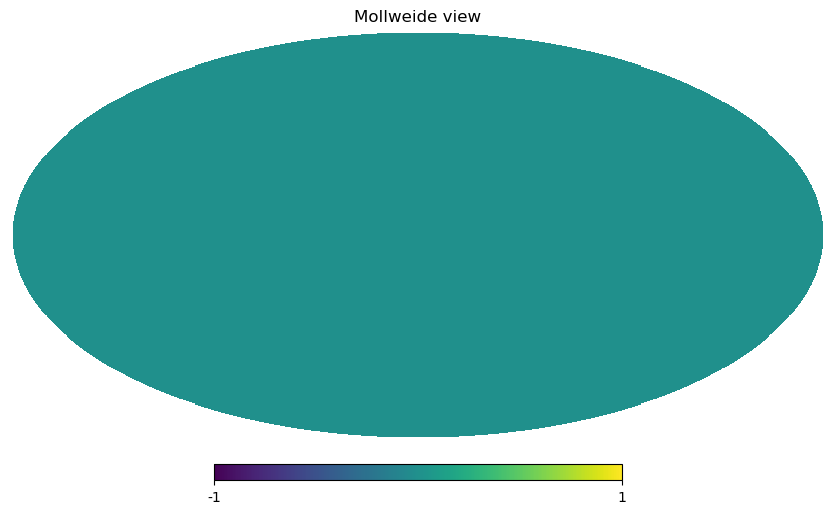

In [36]:
hp.mollview(a)
print(a[0])
print(b[0])
print(np.abs(a[0] - b[0])/a[0])

## Transmitivity atmosphere

In [37]:
acq.scene.atmosphere.transmission

1.0

## Aperture Operator

Convert $W / m^2 / Hz$ to $W / Hz$.
It is a homothety of value $ \lambda = N_{horn}S_{horn} = N_{horn}\pi r^2$

In [38]:
test_ap = []
for i in range(nsub_max):
    Ap = Ap_list[i]
    test_ap.append(Ap(input_maps_ones[i]))

In [39]:
test_ap[0].shape

(196608, 3)

Text(0.5, 0, 'Frequency (GHz)')

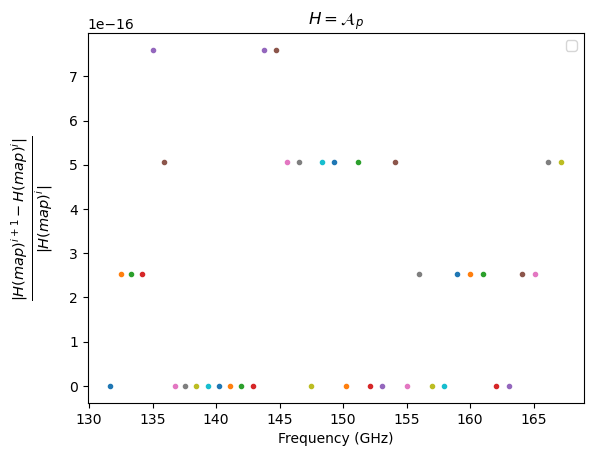

In [40]:
plt.figure()
for i in range(nsub_max-1):
    plt.plot(acq.allnus[i], np.mean(np.abs((test_ap[i+1] - test_ap[i])/test_ap[i])), '.')
plt.legend()
plt.title(r"$H = \mathcal{A}_p$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'Frequency (GHz)')

Text(0, 0.5, 'Effective horn radius')

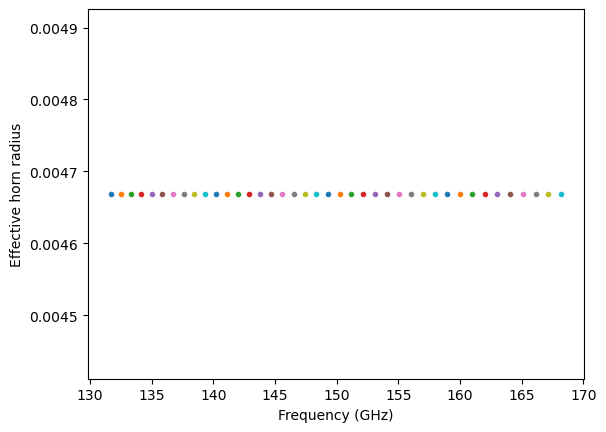

In [41]:
for i in range(nsub_max):
    plt.plot(acq.allnus[i], acq.multiinstrument[i].horn.radeff, '.')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Effective horn radius')

In [42]:
print(acq.multiinstrument[0].horn.radius)

0.0066


## Filter operator

In [43]:
test_filt = []
for i in range(nsub_max):
    Filt = Filt_list[i]
    test_filt.append(Filt(input_maps_ones[i]))

In [44]:
test_filt[0].shape

(196608, 3)

In [45]:
acq.allnus

array([131.6636107 , 132.49343895, 133.3284973 , 134.16881872,
       135.01443639, 135.86538368, 136.72169418, 137.5834017 ,
       138.45054025, 139.32314407, 140.20124759, 141.08488548,
       141.97409262, 142.86890411, 143.76935528, 144.67548166,
       145.58731903, 146.50490339, 147.42827095, 148.35745816,
       149.2925017 , 150.23343849, 151.18030566, 152.13314059,
       153.0919809 , 154.05686443, 155.02782927, 156.00491376,
       156.98815645, 157.97759618, 158.97327198, 159.97522317,
       160.98348929, 161.99811015, 163.0191258 , 164.04657655,
       165.08050295, 166.12094581, 167.16794621, 168.22154547,
       193.10662903, 194.32371046, 195.5484627 , 196.78093413,
       198.02117337, 199.2692294 , 200.52515147, 201.78898916,
       203.06079237, 204.3406113 , 205.62849646, 206.9244987 ,
       208.22866917, 209.54105936, 210.86172107, 212.19070644,
       213.52806792, 214.8738583 , 216.22813072, 217.59093863,
       218.96233583, 220.34237645, 221.73111496, 223.12

Text(0.5, 0, 'Frequency (GHz)')

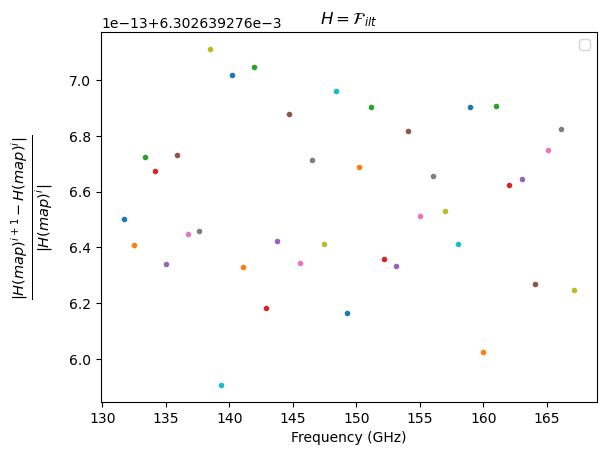

In [46]:
plt.figure()
for i in range(0, len(nsub_list)-1):
    plt.plot(acq.allnus[i], np.mean(np.abs((test_filt[i+1][..., 0] - test_filt[i][..., 0])/test_filt[i][..., 0])), '.')
plt.legend()
plt.title(r"$H = \mathcal{F}_{ilt}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')


Text(0, 0.5, 'Filter bandwidth (GHz)')

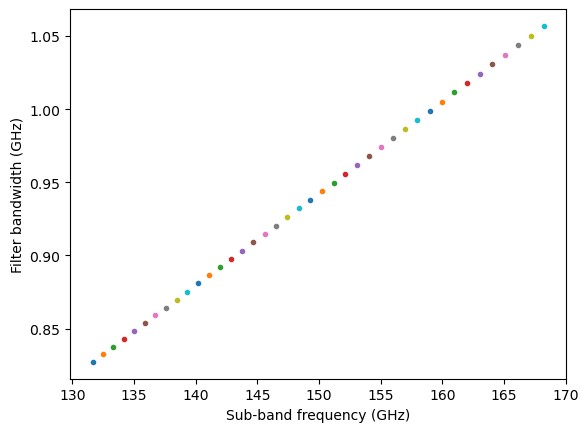

In [47]:
bandwidth_list = []
for i in range(nsub_max):
    bandwidth_list.append(acq.multiinstrument[i].filter.bandwidth/1e9)
    plt.plot(acq.allnus[i], acq.multiinstrument[i].filter.bandwidth/1e9, '.')
plt.xlabel('Sub-band frequency (GHz)')
plt.ylabel('Filter bandwidth (GHz)')

Text(0, 0.5, 'Frequency (GHz)')

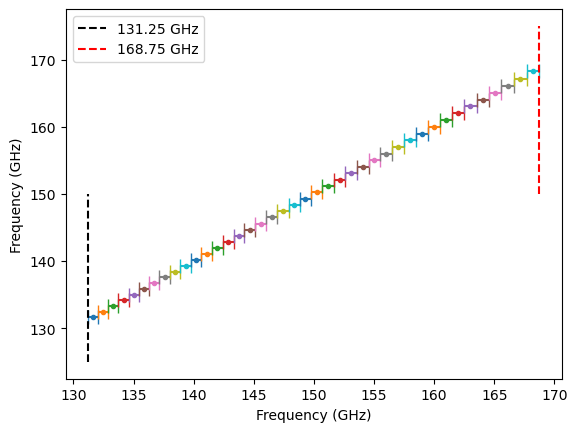

In [48]:
for i in range(nsub_max):
    plt.errorbar(acq.multiinstrument[i].filter.nu/1e9, acq.multiinstrument[i].filter.nu/1e9, xerr=acq.multiinstrument[i].filter.bandwidth/2e9, capsize=5, fmt='.')
plt.vlines(131.25, 125, 150, color='black', linestyle='--', label='131.25 GHz')
plt.vlines(168.75, 150, 175, color='red', linestyle='--', label='168.75 GHz')
plt.legend(loc='upper left')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Frequency (GHz)')

In [49]:
def compute_freq(band, Nfreq=None, relative_bandwidth=0.25):
    """
    Prepare frequency bands parameters
    band -- int,
        QUBIC frequency band, in GHz.
        Typical values: 150, 220
    relative_bandwidth -- float, optional
        Ratio of the difference between the edges of the
        frequency band over the average frequency of the band:
        2 * (nu_max - nu_min) / (nu_max + nu_min)
        Typical value: 0.25
    Nfreq -- int, optional
        Number of frequencies within the wide band.
        If not specified, then Nfreq = 15 if band == 150
        and Nfreq = 20 if band = 220
    """

    if Nfreq is None:
        Nfreq = {150: 15, 220: 20}[band]

    nu_min = band * (1 - relative_bandwidth / 2)
    nu_max = band * (1 + relative_bandwidth / 2)

    Nfreq_edges = Nfreq + 1
    base = (nu_max / nu_min) ** (1. / Nfreq)

    nus_edge = nu_min * np.logspace(0, Nfreq, Nfreq_edges, endpoint=True, base=base)
    nus = np.array([(nus_edge[i] + nus_edge[i - 1]) / 2 for i in range(1, Nfreq_edges)])
    deltas = np.array([(nus_edge[i] - nus_edge[i - 1]) for i in range(1, Nfreq_edges)])
    Delta = nu_max - nu_min
    Nbbands = len(nus)
    return Nfreq_edges, nus_edge, nus, deltas, Delta, Nbbands


Nf, nus_edge, filter_nus, deltas, Delta, Nbbands = compute_freq(
    150, Nfreq=10-1, relative_bandwidth=0.25)

In [50]:
deltas_trap_filter_nus = np.array([IntegrationTrapezeOperator(filter_nus).operands[i].todense(shapein=1)[0][0] for i in range(len(filter_nus))])
deltas_trap_nus_edge = np.array([IntegrationTrapezeOperator(nus_edge).operands[i].todense(shapein=1)[0][0] for i in range(len(nus_edge))])

Text(0, 0.5, 'Frequency (GHz)')

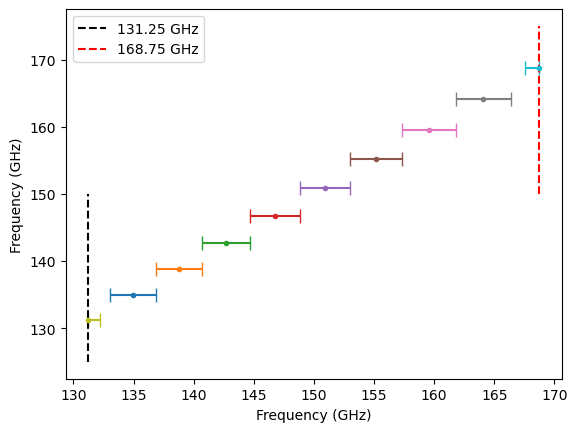

In [51]:
for i in range(1, 10-1):
    plt.errorbar(nus_edge[i], nus_edge[i], xerr=deltas_trap_nus_edge[i]/2, capsize=5, fmt='.')
plt.errorbar(nus_edge[0], nus_edge[0], xerr=[[0], [deltas_trap_nus_edge[0]/2]], capsize=5, fmt='.')
plt.errorbar(nus_edge[-1], nus_edge[-1], xerr=[[deltas_trap_nus_edge[-1]/2], [0]], capsize=5, fmt='.')
plt.vlines(131.25, 125, 150, color='black', linestyle='--', label='131.25 GHz')
plt.vlines(168.75, 150, 175, color='red', linestyle='--', label='168.75 GHz')
plt.legend(loc='upper left')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Frequency (GHz)')

Text(0, 0.5, 'Bandwidth (GHz)')

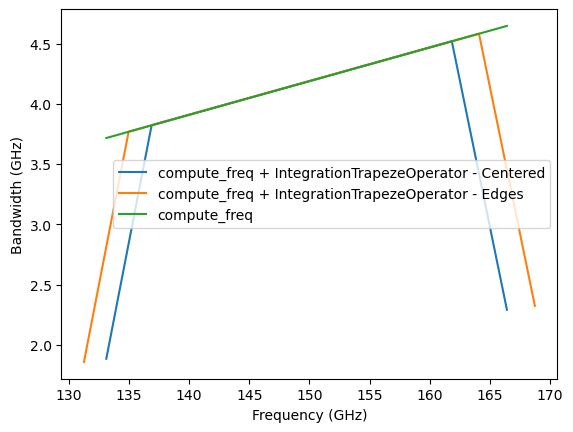

In [52]:
plt.plot(filter_nus, deltas_trap_filter_nus, label='compute_freq + IntegrationTrapezeOperator - Centered')
plt.plot(nus_edge, deltas_trap_nus_edge, label='compute_freq + IntegrationTrapezeOperator - Edges')
plt.plot(filter_nus, deltas, label='compute_freq')
plt.legend()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Bandwidth (GHz)')

In [53]:
print(filter_nus)
print(nus_edge)

[133.10832608 136.8776011  140.753612   144.73938126 148.83801694
 153.05271512 157.38676238 161.84353838 166.42651846]
[131.25       134.96665215 138.78855005 142.71867396 146.76008856
 150.91594532 155.18948492 159.58403984 164.10303691 168.75      ]


In [54]:
print(np.sum(deltas_trap_filter_nus / filter_nus))
print(np.sum(deltas_trap_nus_edge / nus_edge))
print(np.sum(deltas / filter_nus))

0.22341963514719249
0.25134708954059154
0.25129809956094606


In [55]:
print(Delta / 150)

0.25


## Projection Operator

In [56]:
test_proj = []

for i in range(nsub_max):
    Proj = Proj_list[i]
    test_proj.append(Proj(input_maps_ones[i]))

In [57]:
test_proj[0].shape

(992, 9, 3)

Text(0.5, 0, 'Frequency (GHz)')

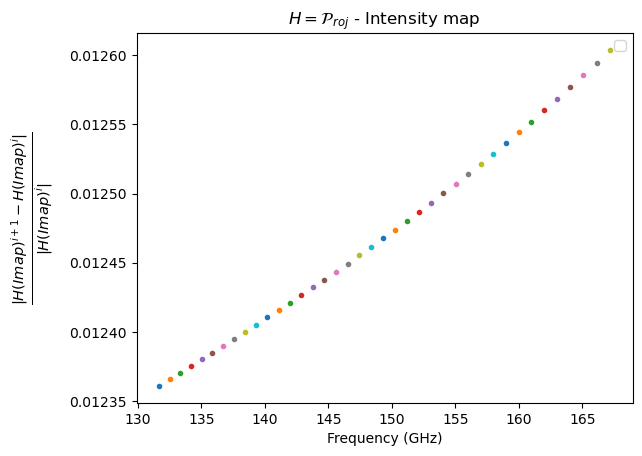

In [58]:
plt.figure()
for i in range(len(nsub_list)-1):
    diff = np.abs((test_proj[i+1][:, 0, 0] - test_proj[i][:, 0, 0])/test_proj[i][:, 0, 0])
    # Need to remove 'nan' due to division by 0
    mean_diff = np.mean(diff[~np.isnan(diff)])
    plt.plot(acq.allnus[i], mean_diff, '.')
plt.legend()
plt.title(r"$H = \mathcal{P}_{roj}$ - Intensity map")
plt.ylabel(r'$\frac{| H(Imap)^{i+1} - H(Imap)^i |}{| H(Imap)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')

Text(0.5, 0, 'Frequency (GHz)')

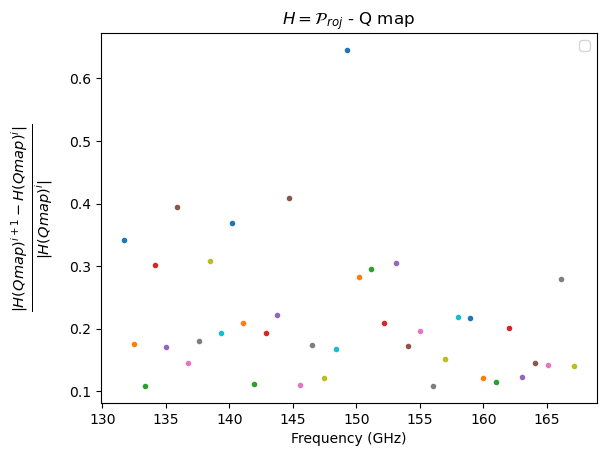

In [59]:
plt.figure()
for i in range(len(nsub_list)-1):
    diff = np.abs((test_proj[i+1][..., 1] - test_proj[i][..., 1])/test_proj[i][..., 1])
    # Need to remove 'nan' due to division by 0
    mean_diff = np.mean(diff[~np.isnan(diff)])
    plt.plot(acq.allnus[i], mean_diff, '.')
plt.legend()
plt.title(r"$H = \mathcal{P}_{roj}$ - Q map")
plt.ylabel(r'$\frac{| H(Qmap)^{i+1} - H(Qmap)^i |}{| H(Qmap)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')

Text(0, 0.5, '$H(map)^{i}$')

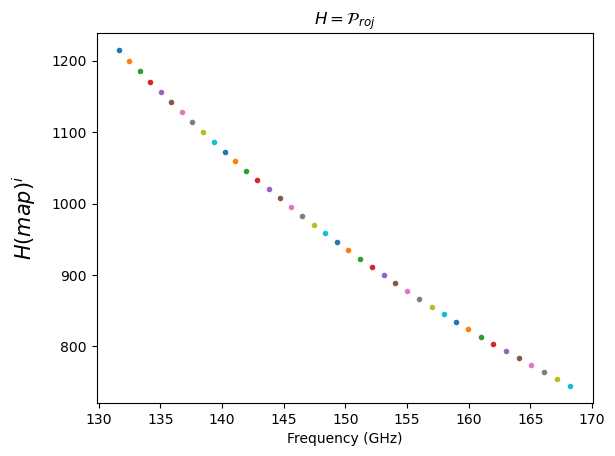

In [60]:
for i in range(nsub_max):
    plt.plot(acq.allnus[i], np.mean(test_proj[i][..., 0]), '.')
plt.xlabel('Frequency (GHz)')
plt.title(r"$H = \mathcal{P}_{roj}$")
plt.ylabel(r'$H(map)^{i}$', fontsize=15, labelpad=10)

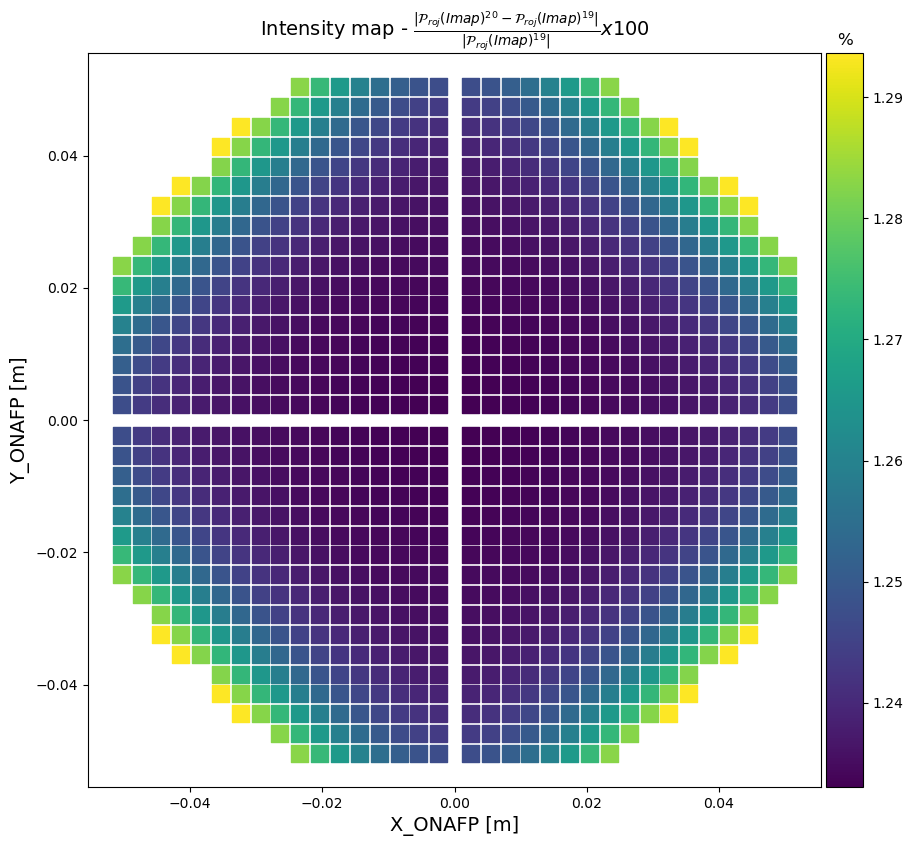

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(test_proj[20]-test_proj[19])/test_proj[19]*100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff[...,0], axis=1), frame='ONAFP', s=150, title=r'Intensity map - $\frac{| \mathcal{P}_{roj}(Imap)^{20} - \mathcal{P}_{roj}(Imap)^{19} |}{| \mathcal{P}_{roj}(Imap)^{19} |} x 100$', fig=fig, ax = ax, unit='%')

In [62]:
test_proj[0].shape

(992, 9, 3)

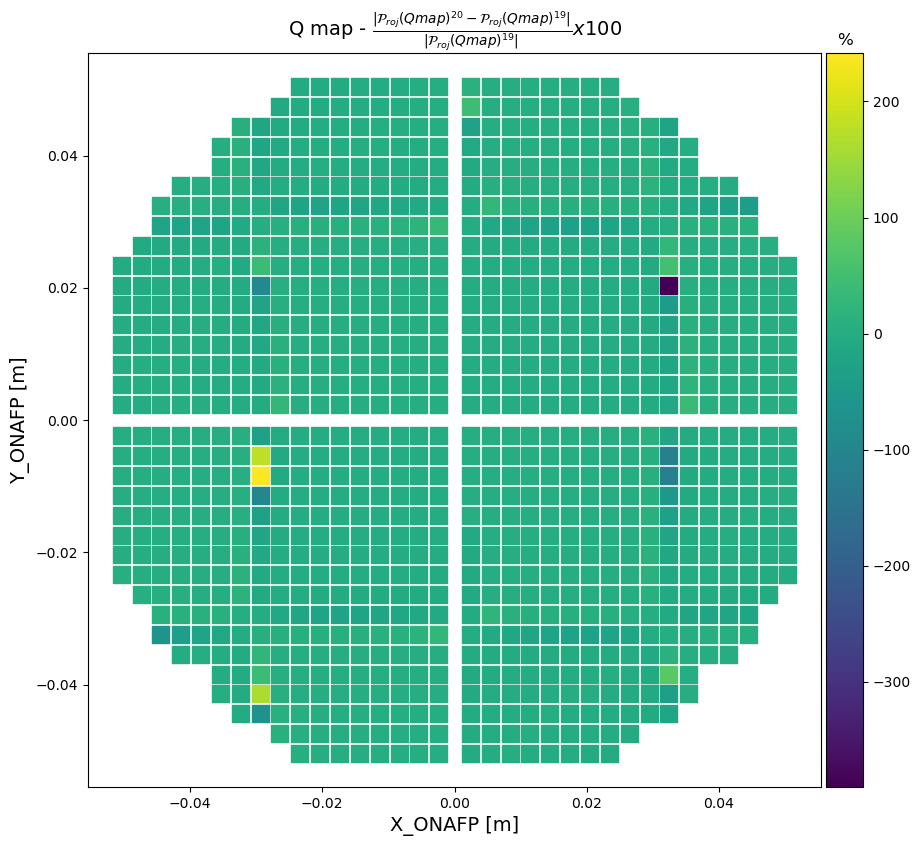

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(test_proj[20]-test_proj[19])/test_proj[19]*100
scatter_plot_FP(q, xTES, yTES, relative_diff[:, 0, 1], frame='ONAFP', s=150, title=r'Q map - $\frac{| \mathcal{P}_{roj}(Qmap)^{20} - \mathcal{P}_{roj}(Qmap)^{19} |}{| \mathcal{P}_{roj}(Qmap)^{19} |} x 100$', fig=fig, ax = ax, unit='%')

Text(0.5, 0.98, 'Projection matrix elements for a given detector at a given time - Uniform sky')

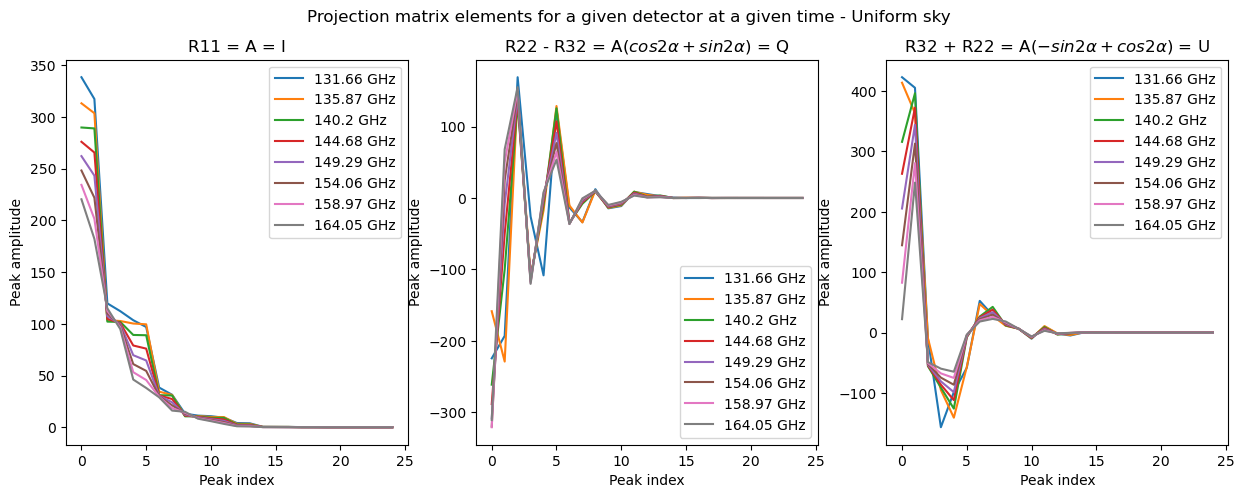

In [64]:
idet, isamples = 0, 50
stokes = ['R11 = A = I', r'R22 - R32 = A($cos2\alpha + sin2\alpha$) = Q', r'R32 + R22 = A($- sin2\alpha + cos2\alpha$) = U']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0, nsub_max, 5):
    P = Proj_list[i]
    amplitude_I = P.matrix.data.r11[len(acq.sampling.index)*idet+isamples]
    amplitude_Q = P.matrix.data.r22[len(acq.sampling.index)*idet+isamples] - P.matrix.data.r32[len(acq.sampling.index)*idet+isamples]
    amplitude_U = P.matrix.data.r22[len(acq.sampling.index)*idet+isamples] + P.matrix.data.r32[len(acq.sampling.index)*idet+isamples]
    amplitude = np.array([amplitude_I, amplitude_Q, amplitude_U])
    index = P.matrix.data.index[len(acq.sampling.index)*idet+isamples]
    for istk in range(3):
        ax[istk].plot(amplitude[istk], label=f'{round(acq.allnus[i],2)} GHz')
        ax[istk].set_title(f'{stokes[istk]}')
        ax[istk].set_xlabel('Peak index')
        ax[istk].set_ylabel('Peak amplitude')
        ax[istk].legend()
fig.suptitle('Projection matrix elements for a given detector at a given time - Uniform sky')

In [65]:
alpha_from_r22 = 0.5 * np.arccos(P.matrix.data.r22 / P.matrix.data.r11)
alpha_from_r32 = 0.5 * np.arcsin(- P.matrix.data.r32 / P.matrix.data.r11)

cos2_sin2 = (P.matrix.data.r22**2 + P.matrix.data.r32**2) / P.matrix.data.r11**2

In [66]:
alpha_from_r22.shape

(8928, 25)

Text(0, 0.5, 'Angle (rad)')

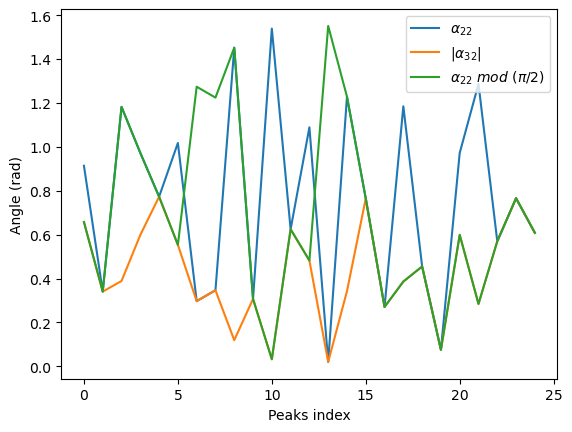

In [121]:
plt.plot(alpha_from_r22[0], label=r'$\alpha_{22}$')
#plt.plot(alpha_from_r32[0], label=r'$\alpha_{32}$')
plt.plot(np.abs(alpha_from_r32[0]), label=r'$|\alpha_{32}|$')
# plt.plot(alpha_from_r22[0] % (np.pi/2), label=r'$\alpha_{22}$ mod $\pi/2$')
plt.plot(alpha_from_r32[0] % (np.pi/2), label=r'$\alpha_{22} \ mod \ (\pi/2)$')
plt.legend()
plt.xlabel('Peaks index')
plt.ylabel('Angle (rad)')

Text(0, 0.5, 'Angle (rad)')

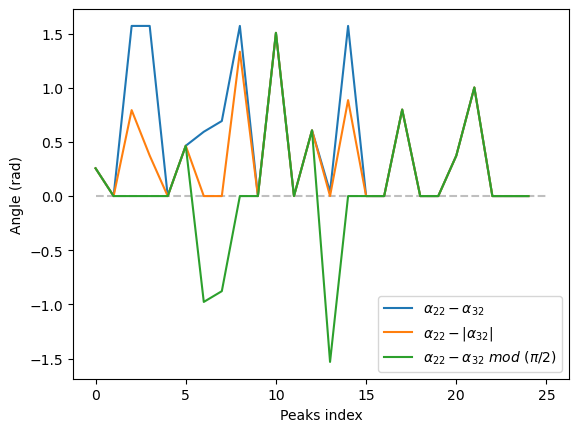

In [123]:
plt.hlines(0, 0, len(alpha_from_r22[0]), 'grey', linestyle='--', alpha=0.5)
plt.plot(alpha_from_r22[0] - (alpha_from_r32[0]), label=r'$\alpha_{22} - \alpha_{32}$')
plt.plot(alpha_from_r22[0] - np.abs(alpha_from_r32[0]), label=r'$\alpha_{22} - |\alpha_{32}|$')
plt.plot(alpha_from_r22[0] - (alpha_from_r32[0] % (np.pi/2)), label=r'$\alpha_{22} - \alpha_{32} \ mod \ (\pi/2)$')
plt.legend()
plt.xlabel('Peaks index')
plt.ylabel('Angle (rad)')

Text(0, 0.5, 'Angle (deg)')

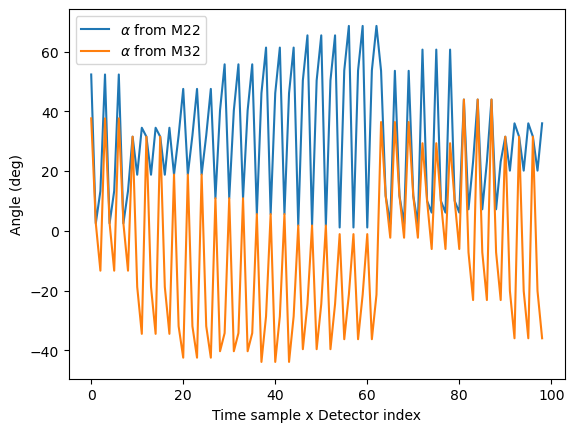

In [70]:
plt.plot(np.degrees(alpha_from_r22[:99, 0]), label=r'$\alpha$ from M22')
plt.plot(np.degrees(alpha_from_r32[:99, 0]), label=r'$\alpha$ from M32')
#plt.plot(acq.sampling.pitch, label='pitch angle')
plt.legend()
plt.xlabel('Time sample x Detector index')
plt.ylabel('Angle (deg)')

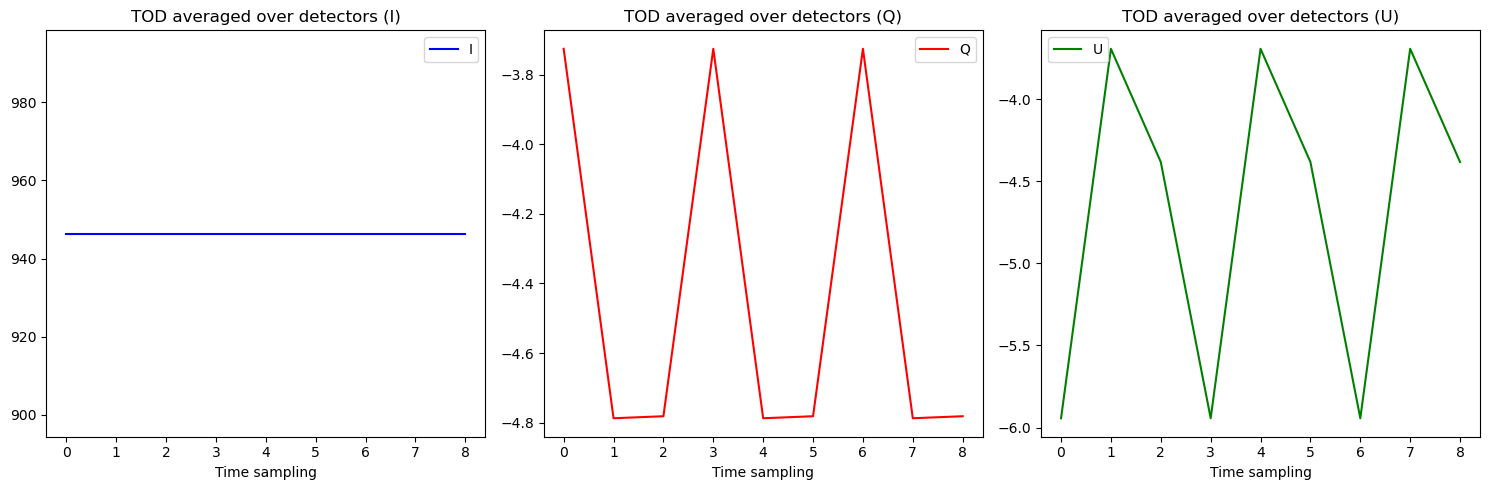

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(np.mean(test_proj[20][..., 0], axis=0), 'b', label='I')
ax1.legend()
ax1.set_title('TOD averaged over detectors (I)')
ax1.set_xlabel('Time sampling')

ax2.plot(np.mean(test_proj[20][..., 1], axis=0), 'r', label='Q')
ax2.legend()
ax2.set_title('TOD averaged over detectors (Q)')
ax2.set_xlabel('Time sampling')

ax3.plot(np.mean(test_proj[20][..., 2], axis=0), 'g', label='U')
ax3.legend()
ax3.set_title('TOD averaged over detectors (U)')
ax3.set_xlabel('Time sampling')

plt.tight_layout()

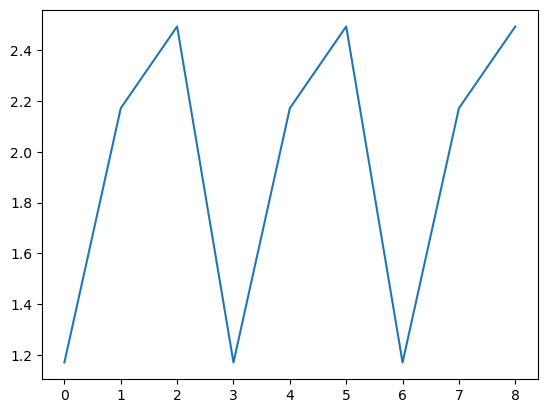

In [72]:
plt.plot(np.radians(sampling.pitch))

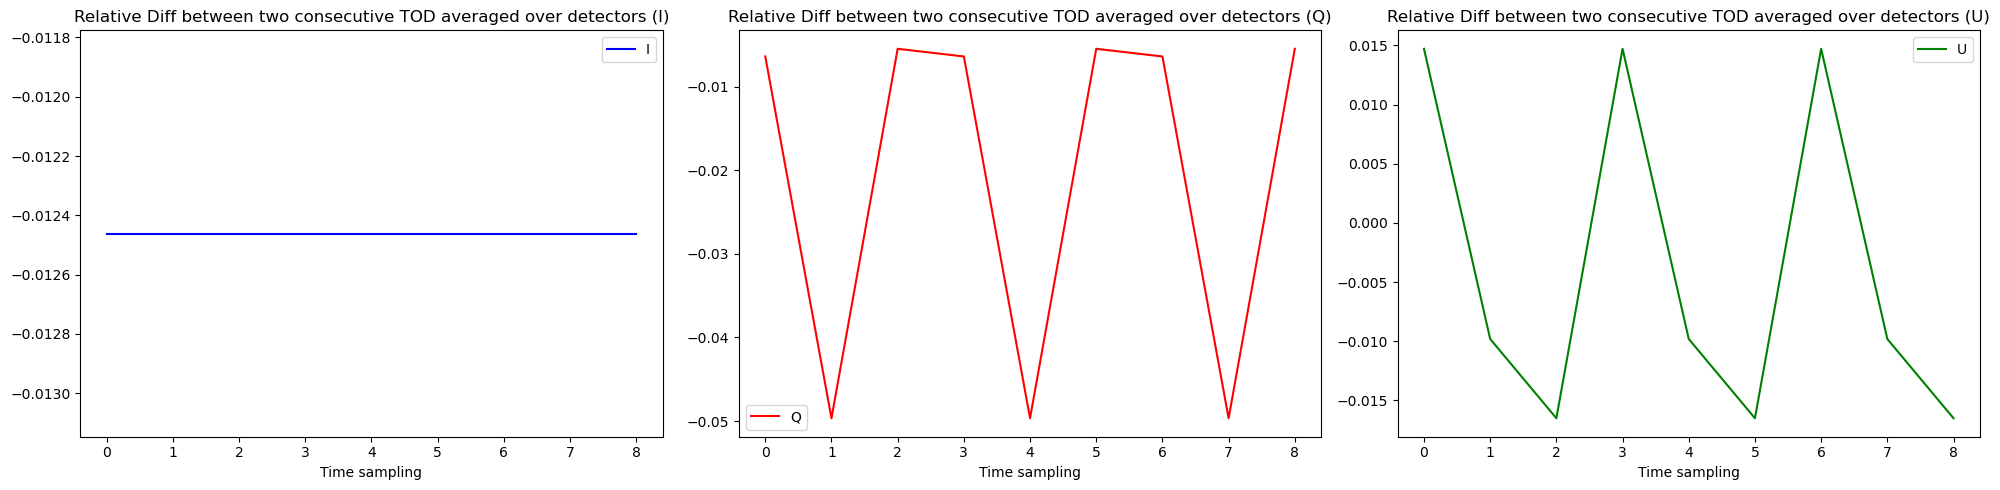

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(np.mean((test_proj[20][..., 0]-test_proj[19][..., 0])/test_proj[19][..., 0], axis=0), 'b', label='I')
ax1.legend()
ax1.set_title('Relative Diff between two consecutive TOD averaged over detectors (I)')
ax1.set_xlabel('Time sampling')

ax2.plot(np.mean((test_proj[20][..., 1]-test_proj[19][..., 1])/test_proj[19][..., 1], axis=0), 'r', label='Q')
ax2.legend()
ax2.set_title('Relative Diff between two consecutive TOD averaged over detectors (Q)')
ax2.set_xlabel('Time sampling')

ax3.plot(np.mean((test_proj[20][..., 2]-test_proj[19][..., 2])/test_proj[19][..., 2], axis=0), 'g', label='U')
ax3.legend()
ax3.set_title('Relative Diff between two consecutive TOD averaged over detectors (U)')
ax3.set_xlabel('Time sampling')

plt.tight_layout()

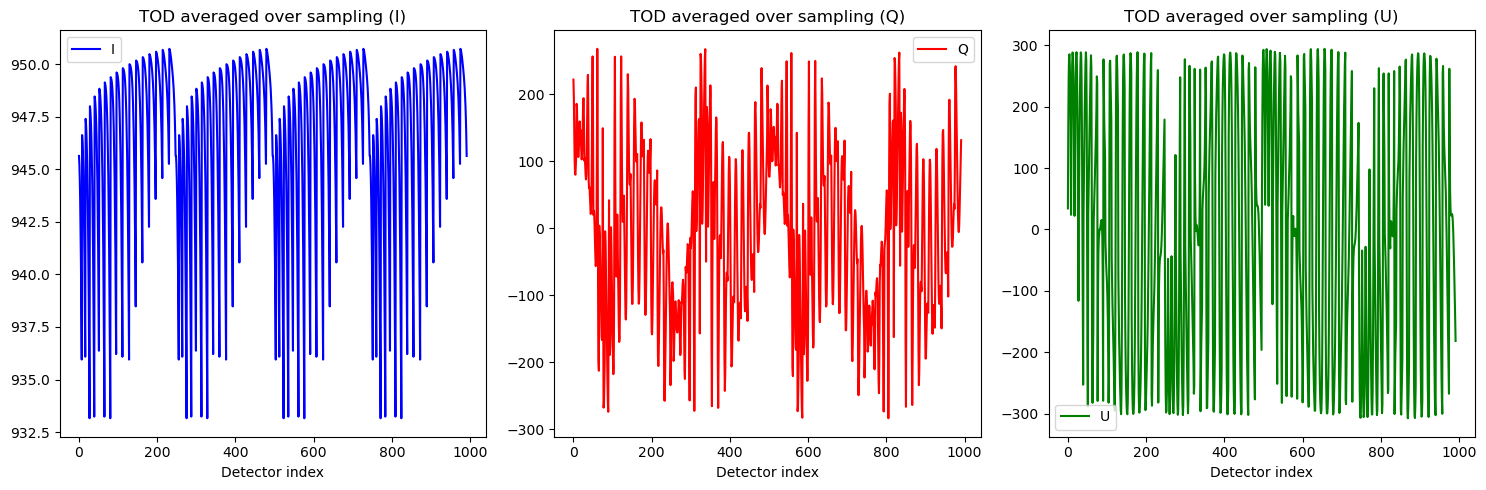

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(np.mean(test_proj[20][..., 0], axis=1), 'b', label='I')
ax1.legend()
ax1.set_title('TOD averaged over sampling (I)')
ax1.set_xlabel('Detector index')

ax2.plot(np.mean(test_proj[20][..., 1], axis=1), 'r', label='Q')
ax2.legend()
ax2.set_title('TOD averaged over sampling (Q)')
ax2.set_xlabel('Detector index')

ax3.plot(np.mean(test_proj[20][..., 2], axis=1), 'g', label='U')
ax3.legend()
ax3.set_title('TOD averaged over sampling (U)')
ax3.set_xlabel('Detector index')

plt.tight_layout()


In [75]:
print(np.mean(test_proj[20][:int(992/4), :, 0]) - np.mean(test_proj[20][int(992/4):int(992/2), :, 0]))

0.0


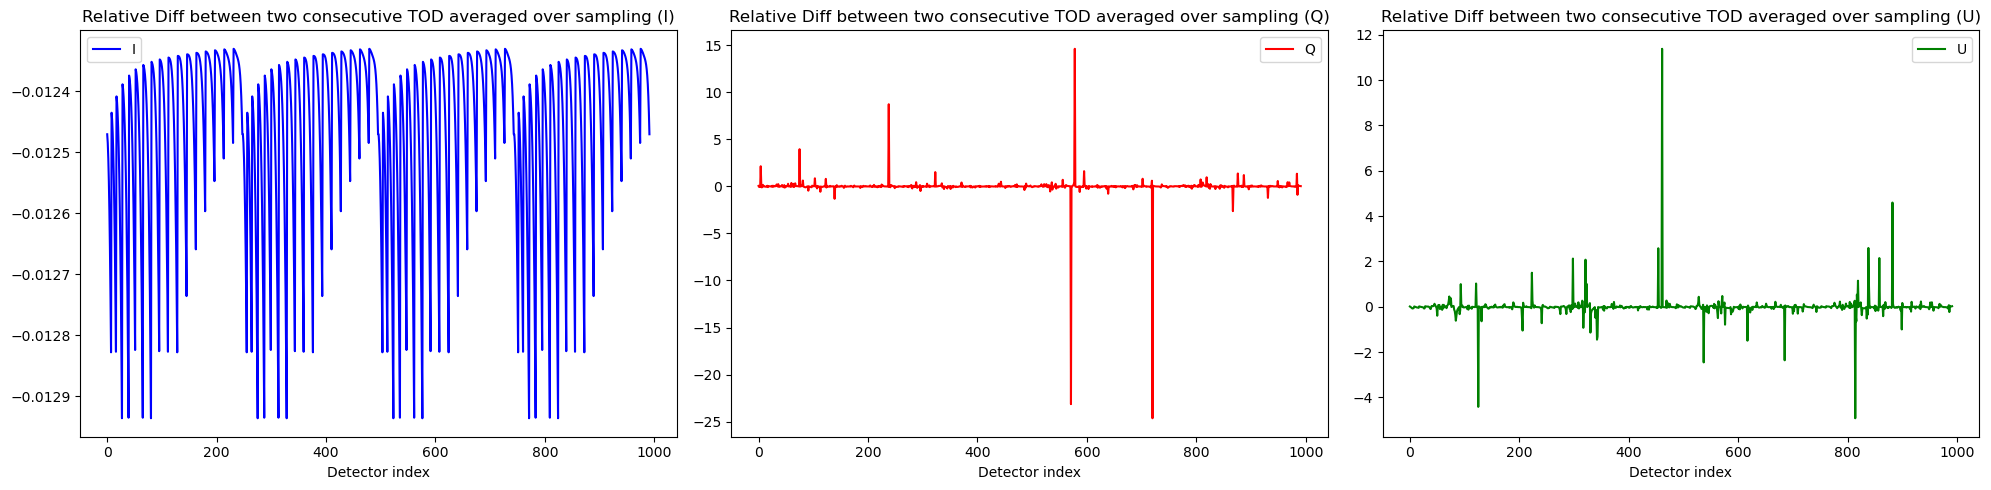

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(np.mean((test_proj[20][..., 0]-test_proj[19][..., 0])/test_proj[19][..., 0], axis=1), 'b', label='I')
ax1.legend()
ax1.set_title('Relative Diff between two consecutive TOD averaged over sampling (I)')
ax1.set_xlabel('Detector index')

ax2.plot(np.mean((test_proj[20][..., 1]-test_proj[19][..., 1])/test_proj[19][..., 1], axis=1), 'r', label='Q')
ax2.legend()
ax2.set_title('Relative Diff between two consecutive TOD averaged over sampling (Q)')
ax2.set_xlabel('Detector index')

ax3.plot(np.mean((test_proj[20][..., 2]-test_proj[19][..., 2])/test_proj[19][..., 2], axis=1), 'g', label='U')
ax3.legend()
ax3.set_title('Relative Diff between two consecutive TOD averaged over sampling (U)')
ax3.set_xlabel('Detector index')

plt.tight_layout()

## Half-Wave Plate Operator

In [77]:
test_hwp = []
for i in range(nsub_max):
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_hwp.append((Hwp * Proj)(input_maps_ones[i]))

In [78]:
test_hwp[0].shape

(992, 9, 3)

Text(0.5, 0, '$i$')

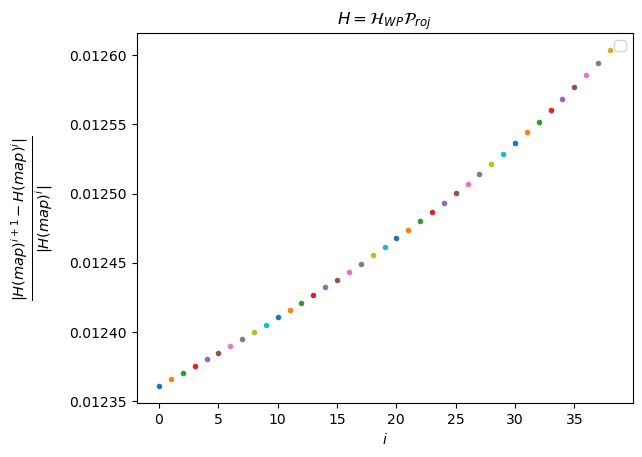

In [79]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_hwp[i+1][..., 0] - test_hwp[i][..., 0])/test_hwp[i][..., 0])), '.')
plt.legend()
plt.title(r"$H = \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Polarizer Operator

In [80]:
test_pol = []
for i in range(nsub_max):
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_pol.append((Pol * Hwp * Proj)(input_maps_ones[i]))

In [81]:
test_pol[0].shape

(992, 9)

Text(0.5, 0, '$i$')

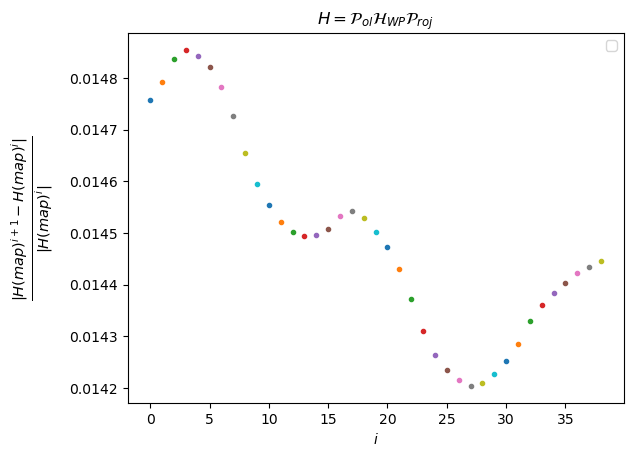

In [82]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_pol[i+1] - test_pol[i])/test_pol[i])), '.')
plt.legend()
plt.title(r"$H = \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Detector Integration Operator

In [83]:
test_idet = []
for i in range(nsub_max):
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_idet.append((Idet * Pol * Hwp * Proj)(input_maps_ones[i]))

In [84]:
test_idet[0].shape

(992, 9)

0.015233307387586381


Text(0.5, 0, '$i$')

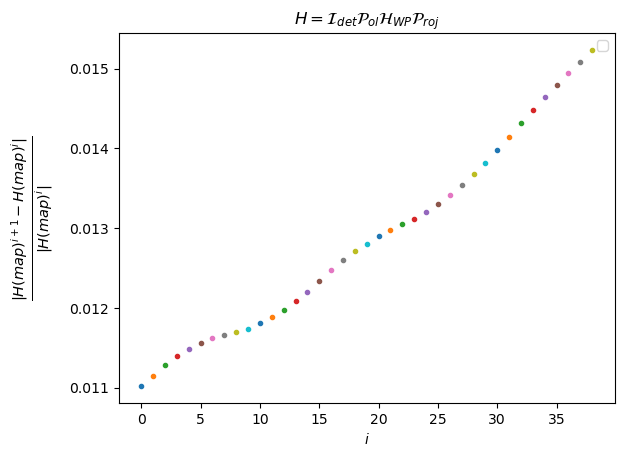

In [85]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_idet[i+1] - test_idet[i])/test_idet[i])), '.')
print(np.mean(np.abs((test_idet[i+1] - test_idet[i])/test_idet[i])))
plt.legend()
plt.title(r"$H = \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Transmission Operator

In [86]:
test_trans = []
for i in range(nsub_max):
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_trans.append((Tinst * Idet * Pol * Hwp * Proj)(input_maps_ones[i]))

In [87]:
test_trans[0].shape

(992, 9)

0.015233307387586392


Text(0.5, 0, '$i$')

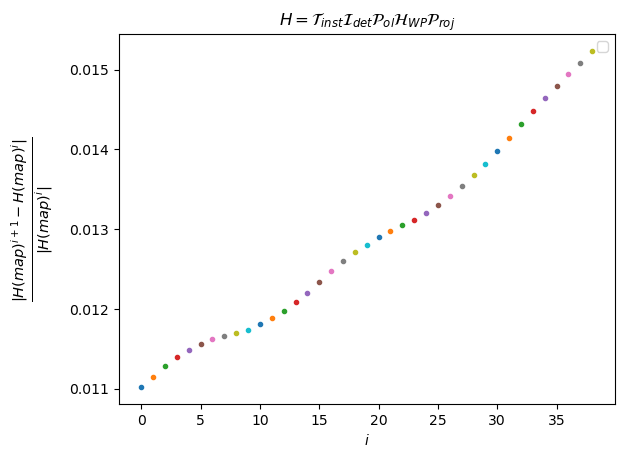

In [88]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_trans[i+1] - test_trans[i])/test_trans[i])), '.')
print(np.mean(np.abs((test_trans[i+1] - test_trans[i])/test_trans[i])))
plt.legend()
plt.title(r"$H = \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Detector Response Operator

In [89]:
test_resp = []
for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    test_resp.append((Rdet * Tinst * Idet * Pol * Hwp * Proj)(input_maps_ones[i]))

In [90]:
test_resp[0].shape

(992, 9)

0.015233307387586374


Text(0.5, 0, '$i$')

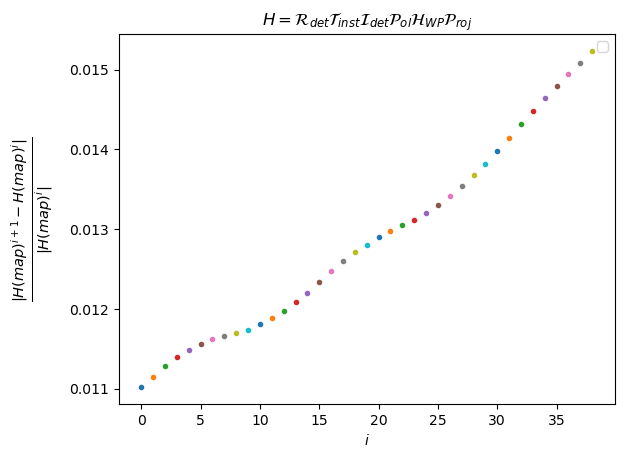

In [91]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_resp[i+1] - test_resp[i])/test_resp[i])), '.')
print(np.mean(np.abs((test_resp[i+1] - test_resp[i])/test_resp[i])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

## Add the first conversion operators

(992, 9)
0.011903780892536972


Text(0.5, 0, '$i$')

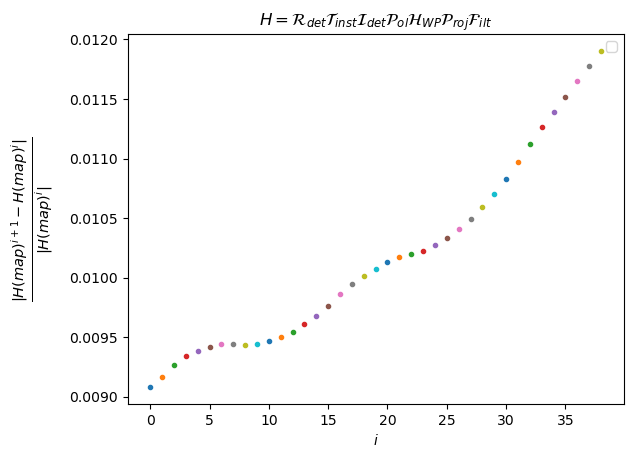

In [92]:
test = []
for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    Filt = Filt_list[i]
    test.append((Rdet * Tinst * Idet * Pol * Hwp * Proj * Filt)(input_maps_ones[i]))

print(test[0].shape)
    
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1] - test[i])/test[i])), '.')
print(np.mean(np.abs((test[i+1] - test[i])/test[i])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj} \mathcal{F}_{ilt}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

0.011903780892537142


Text(0.5, 0, '$i$')

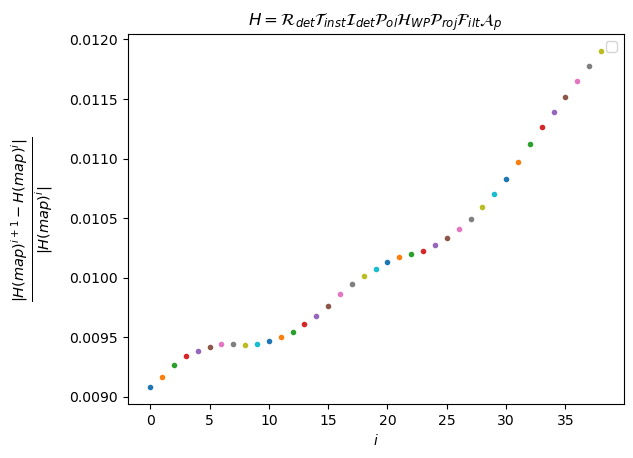

In [93]:
test = []
for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    Filt = Filt_list[i]
    Ap = Ap_list[i]
    test.append((Rdet * Tinst * Idet * Pol * Hwp * Proj * Filt * Ap)(input_maps_ones[i]))
    
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1] - test[i])/test[i])), '.')
print(np.mean(np.abs((test[i+1] - test[i])/test[i])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj} \mathcal{F}_{ilt} \mathcal{A}_p $")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

0.01111788831341179


Text(0.5, 0, '$i$')

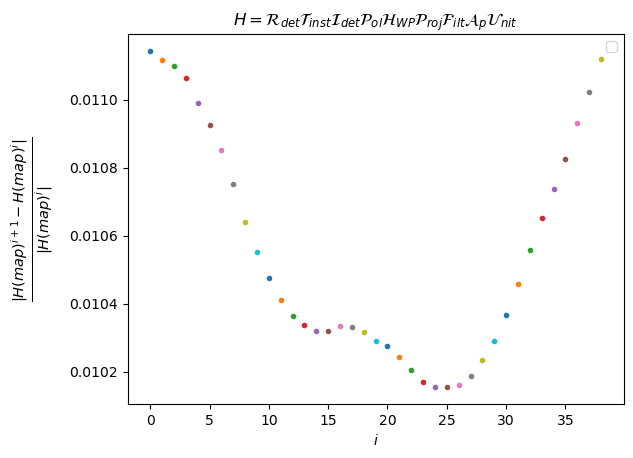

In [94]:
test = []

for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    Filt = Filt_list[i]
    Ap = Ap_list[i]
    Unit = Unit_list[i]
    test.append((Rdet * Tinst * Idet * Pol * Hwp * Proj * Filt * Ap * Unit)(input_maps_ones[i]))
    
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1] - test[i])/test[i])), '.')
print(np.mean(np.abs((test[i+1] - test[i])/test[i])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj} \mathcal{F}_{ilt} \mathcal{A}_p \mathcal{U}_{nit} $")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

0.011117224391082963


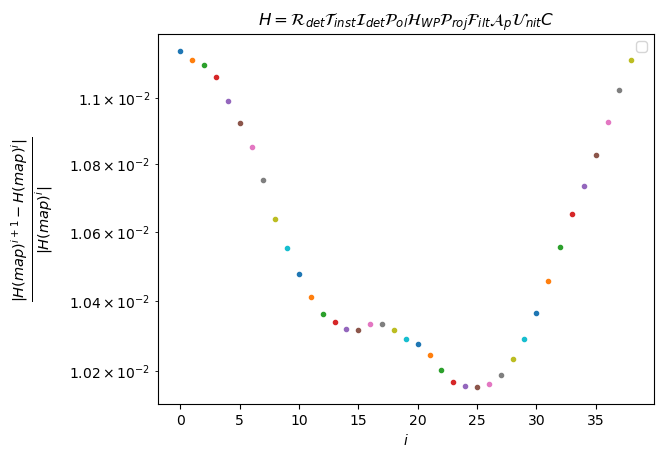

In [95]:
test = []
for i in range(nsub_max):
    Rdet = Rdet_list[i]
    Tinst = Tinst_list[i]
    Idet = Idet_list[i]
    Pol = Pol_list[i]
    Proj = Proj_list[i]
    Hwp = Hwp_list[i]
    Filt = Filt_list[i]
    Ap = Ap_list[i]
    Unit = Unit_list[i]
    C = C_list[i]
    test.append((Rdet * Tinst * Idet * Pol * Hwp * Proj * Filt * Ap * Unit * C)(input_maps_ones[i]))
    
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1] - test[i])/test[i])), '.')
print(np.mean(np.abs((test[i+1] - test[i])/test[i])))
plt.legend()
plt.title(r"$H = \mathcal{R}_{det} \mathcal{T}_{inst} \mathcal{I}_{det} \mathcal{P}_{ol} \mathcal{H}_{WP} \mathcal{P}_{roj} \mathcal{F}_{ilt} \mathcal{A}_p \mathcal{U}_{nit} C $")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')
plt.yscale('log')

In [96]:
test = []
for i in range(nsub_max):
    H_i = acq.subacqs[i].get_operator()
    test.append(H_i(C_list[i](input_maps_ones[i])))

Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3.40576171875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (8928,25) elements = 3

0.011117224391082965


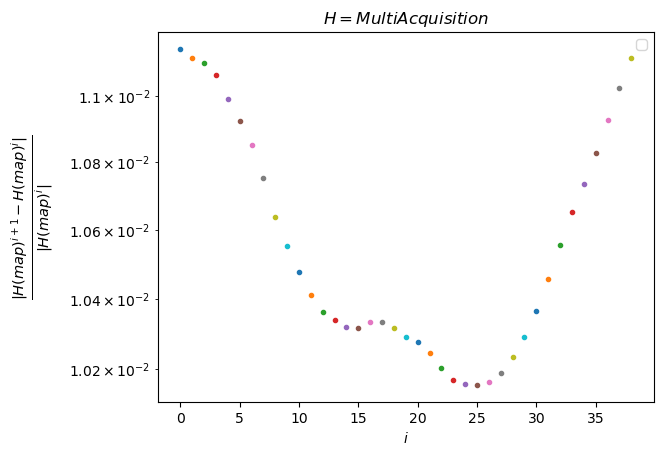

In [97]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test[i+1] - test[i])/test[i])), '.')
print(np.mean(np.abs((test[i+1] - test[i])/test[i])))
plt.legend()
plt.title(r"$H = MultiAcquisition $")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')
plt.yscale('log')

# CMB

In [98]:
TOD_list = []
TOD_ones_list = []
for isub in nsub_list:
    print(isub)
    
    TOD = []
    TOD_ones = []
    acq = QubicMultiAcquisitions(dict_qubic, isub, params['QUBIC']['nrec'], sampling=sampling)
    ext = InputMaps(sky, acq.allnus, params['QUBIC']['nrec'], params['SKY']['nside'])
    
    H = acq.H[:int(isub/2)]
    input_maps = ext.m_nu
    input_maps_ones = np.ones(np.shape(input_maps))
    
    for i in range(int(isub/2)):
        C = HealpixConvolutionGaussianOperator(acq.allfwhm[i])
        TOD.append(H[i](C(input_maps[i])))
        TOD_ones.append(H[i](C(input_maps_ones[i])))
    TOD_list.append(np.sum(TOD, axis=0))
    TOD_ones_list.append(np.sum(TOD_ones, axis=0))
nsub_list = np.arange(4, int(i/2), 4)

0


ZeroDivisionError: float division by zero

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(sampling.index, TOD[-1][det_index], label=f'Nsub = {nsub_list[-1]}', color='black', lw=5)
#plt.plot(sampling.index, TOD_list[5][det_index], label=f'Nsub = {nsub_list[5]}')
plt.plot(sampling.index, TOD[4][det_index], label=f'Nsub = {nsub_list[4]}')
plt.plot(sampling.index, TOD[1][det_index], label=f'Nsub = {nsub_list[1]}')
#plt.plot(sampling.index, TOD_list[0][det_index], label=f'Nsub = {nsub_list[0]}')
plt.legend()

IndexError: list index out of range

<Figure size 1500x800 with 0 Axes>

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], TOD_list[i][det_index][sampling_index], '.')
plt.legend()
plt.title('TOD value for a given detector at a given moment - CMB')
plt.xlabel('Nsub input')

NameError: name 'TOD_list' is not defined

<Figure size 640x480 with 0 Axes>

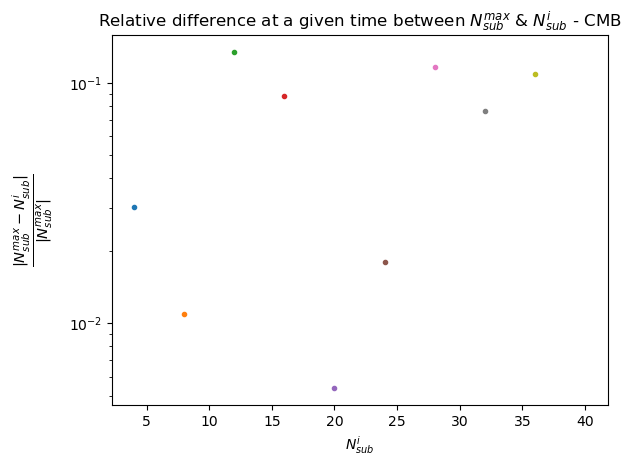

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.abs((TOD_list[-1][det_index, sampling_index] - TOD_list[i][det_index, sampling_index])/TOD_list[-1][det_index, sampling_index]), '.')
plt.title(r"Relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')
plt.yscale('log')

Text(0.5, 0, '$N_{sub}^i$')

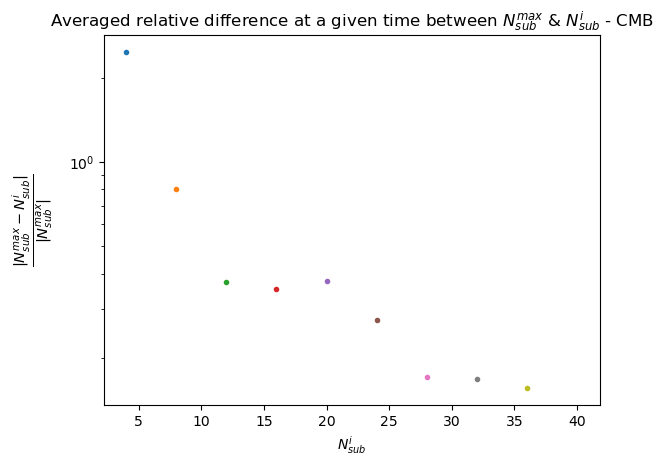

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_list[-1][:, sampling_index] - TOD_list[i][:, sampling_index])/TOD_list[-1][:, sampling_index])), '.')
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

Text(0.5, 0, '$N_{sub}^i$')

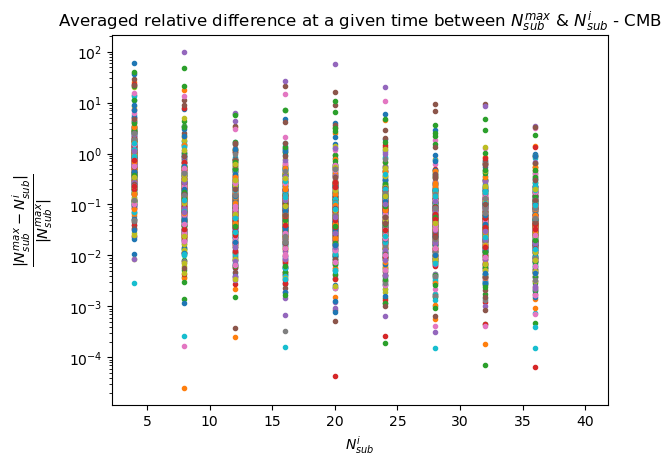

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    for jdet in range(400):
        plt.plot(nsub_list[i], np.abs((TOD_list[-1][jdet, sampling_index] - TOD_list[i][jdet, sampling_index])/TOD_list[-1][jdet, sampling_index]), '.')
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

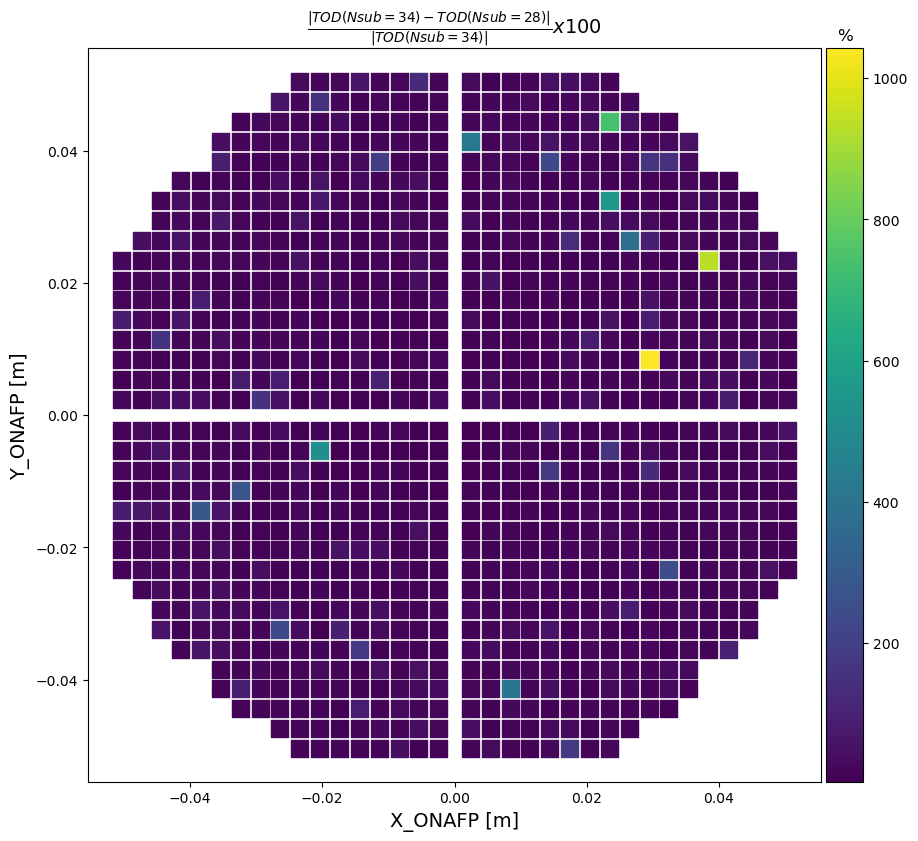

In [ ]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_list[-1] - TOD_list[-2]) / np.abs(TOD_list[-1]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD(Nsub=34) - TOD(Nsub=28) |}{| TOD(Nsub=34) |} x 100$', fig=fig, ax = ax, unit='%')

Text(0.5, 0, '$N_{sub}^i$')

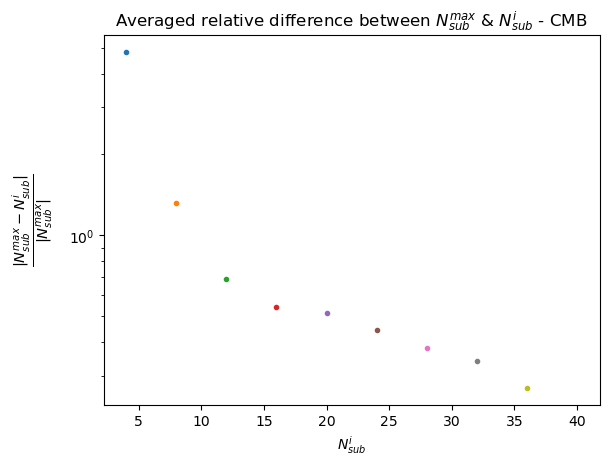

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.mean(np.abs((TOD_list[-1] - TOD_list[i])/TOD_list[-1]), axis=0)), '.')
plt.title(r"Averaged relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

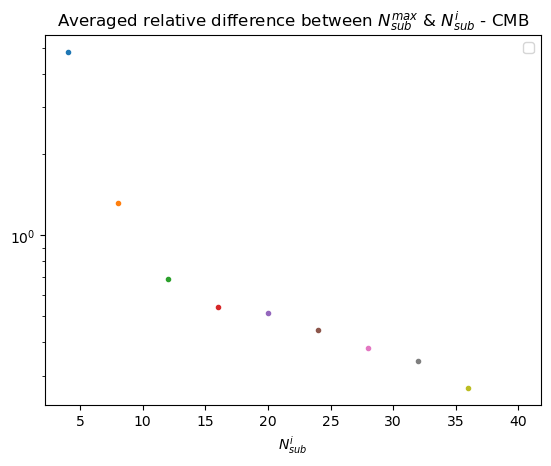

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_list[-1] - TOD_list[i])/TOD_list[-1])), '.')
plt.legend()
plt.title(r"Averaged relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')

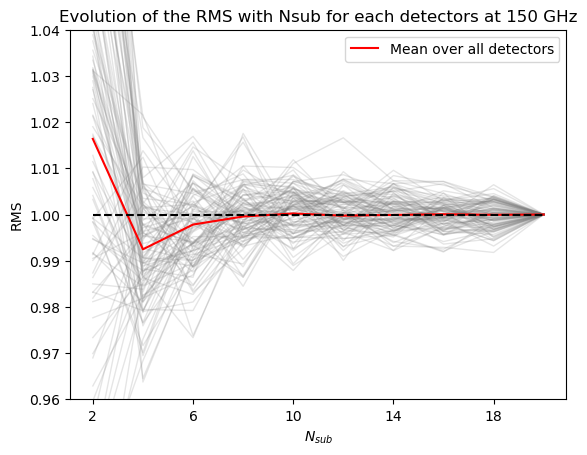

In [ ]:
plt.figure()
for idet in range(100):
    plt.plot(nsub_list/2, np.std(TOD_list, axis=2)[:, idet]/np.std(TOD_list, axis=2)[-1, idet], 'grey', alpha=0.2, linewidth=1)
plt.plot(nsub_list/2, np.mean(np.std(TOD_list, axis=2)/np.std(TOD_list, axis=2)[-1], axis=1), 'r', label='Mean over all detectors')
plt.hlines(1, np.min(nsub_list/2), np.max(nsub_list/2), linestyles='--', colors='k')
plt.xlabel(r'$N_{sub}$')
plt.ylabel('RMS')
plt.xticks(nsub_list[::2]/2)
plt.title('Evolution of the RMS with Nsub for each detectors at 150 GHz')
plt.ylim(0.96, 1.04)
plt.legend()

In [ ]:
np.std(TOD_list[i][jdet])

1.9384328586762935e-18

# Uniform Sky

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

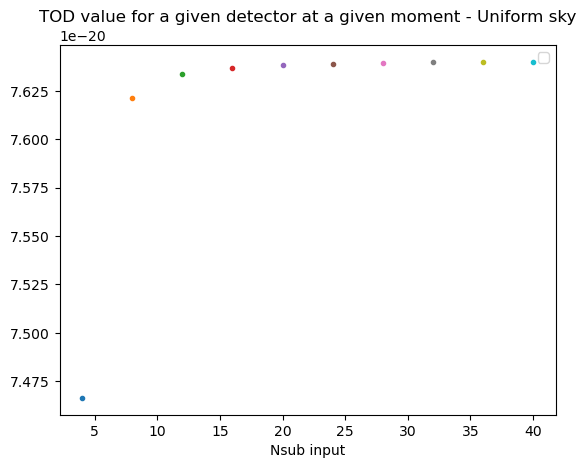

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], TOD_ones_list[i][det_index][sampling_index], '.')#, label=f"Nsub_in = {nsub_list[i]}")
plt.legend()
plt.title('TOD value for a given detector at a given moment - Uniform sky')
plt.xlabel('Nsub input')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

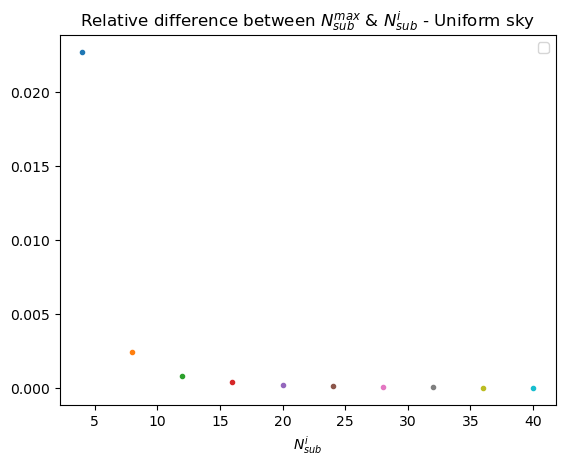

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.abs((TOD_ones_list[-1][det_index, sampling_index] - TOD_ones_list[i][det_index, sampling_index])/TOD_ones_list[-1][det_index, sampling_index]), '.')
plt.legend()
plt.title(r"Relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - Uniform sky")
#plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

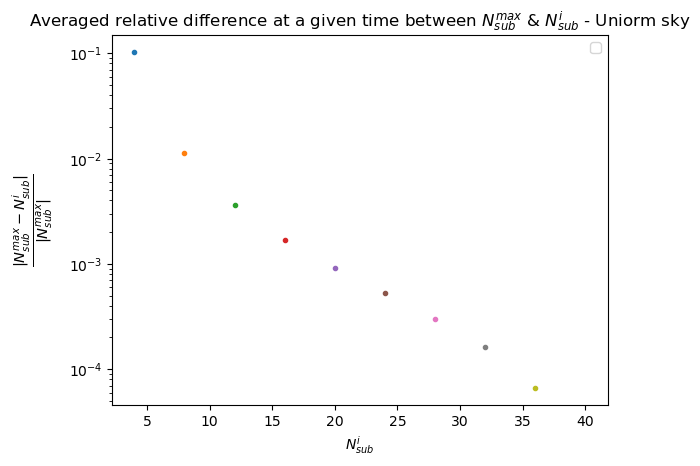

In [ ]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_ones_list[-1][:, sampling_index] - TOD_ones_list[i][:, sampling_index])/TOD_ones_list[-1][:, sampling_index])), '.')
plt.legend()
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - Uniorm sky")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

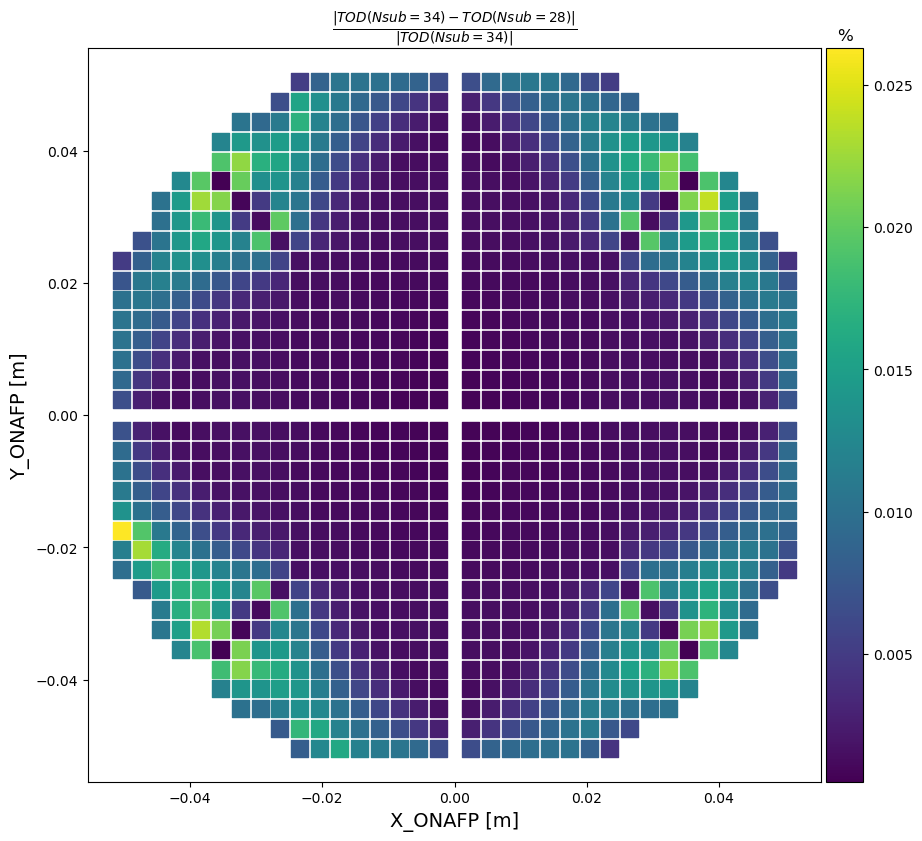

In [ ]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_ones_list[-1] - TOD_ones_list[-2]) / np.abs(TOD_ones_list[-1]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD(Nsub=34) - TOD(Nsub=28) |}{| TOD(Nsub=34) |}$', fig=fig, ax = ax, unit='%')

In [ ]:
stop

NameError: name 'stop' is not defined